# 先import 套件

抓取網站後，需整理資料至dataframe格式

In [58]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

def get_season_report(year,season):

    url = 'https://mops.twse.com.tw/mops/web/t163sb06'
    r = requests.post(url,{'encodeURIComponent':1,'step':1,'firstin':1,'off':1,'isQuery':1,'TYPEK':'sii','year':str(year),'season':str(season)})
    r.encoding = 'utf_8_sig'
    df = pd.read_html(r.text, header = None)
    df = df[9]
    df.columns = [i for i in df.iloc[0]]
    df = df.set_index(['公司代號'])
    df = df.drop(index = ['公司代號'])
    df.columns = ['公司名稱','營收','毛利率','營業利益率','稅前純益率','稅後純益率']

# index = [i for i in range(len(df)) if ['公司代號'] in df[i].columns]
# df = df[index[0]]
# df= df[['公司代號','公司名稱','營業收入','營業毛利（毛損）淨額','稅前淨利（淨損）','本期淨利（淨損）']].set_index('公司代號')


    df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric,errors='coerce')
    return df 

def get_profit_report(year,period):
    
    dict_all = {}
    
    for i in range(period+1):
        for k in range(4):
            try:
                df = get_season_report(year+i,k+1)
                dict_all.update({str(year+i)+'0'+str(k+1):df[['毛利率','稅後純益率']]})
            except:
                break
    time.sleep(5)
    
    return dict_all

dict_all = get_profit_report(104,3)

df_all_gross = pd.concat([dict_all[key]['毛利率'] for key in dict_all.keys()],axis=1,sort=True)
df_all_gross.columns = dict_all.keys()
df_all_gross = df_all_gross.transpose()

df_all_tax = pd.concat([dict_all[key]['稅後純益率'] for key in dict_all.keys()],axis=1,sort=True)
df_all_tax.columns = dict_all.keys()
df_all_tax = df_all_tax.transpose()

print(df_all_tax)

        1101   1102   1103   1104   1108   1109   1110   1201   1203  1210  \
10401   4.55  10.04  -27.3  19.73  12.01   0.16   7.57  -6.94  12.28  0.45   
10402   7.97  14.19   -4.8  23.91  11.71  -1.42   6.35  -5.92   9.57  0.59   
10403   6.79   8.97 -19.65  24.13  10.61  -3.17   8.91  -9.16   9.24  1.06   
10404   7.39   7.44   7.55  26.78   9.22  -1.32   7.78 -10.94   6.93  0.62   
10501   0.53   1.49 -34.92  31.02  10.48  -3.79  56.46  -2.34   7.94  3.37   
10502   6.89   5.27 -18.54  36.64   9.25   2.19  29.88  -5.54   8.19  3.44   
10503   9.66   6.13  -4.93  35.75   8.66   2.53  20.83  -3.15   8.91  3.59   
10504   9.87   7.68   0.31  36.42   7.41   4.09  14.04  -6.35   9.93  3.38   
10601   5.49   1.17 -18.02  25.37   2.08   4.58   6.61   5.19  10.63  3.36   
10602   9.23   7.27  -8.06  30.83   1.61   9.77  -1.47   2.02  11.03  2.73   
10603  10.04   9.55  -0.73   30.6    0.8  10.15   0.47   1.35  12.47  3.15   
10604   10.5  10.27  46.64  31.54     -3  13.21    3.4   5.03  1

# 選取前五季稅後純益率年成長及毛利率年成長>0的股票

In [61]:
df_all_1 = df_all_gross>df_all_gross.shift(4)
df_all_2 = df_all_tax>df_all_tax.shift(4)
method_1 = df_all_1.iloc[-5:].sum()
method_2 = df_all_2.iloc[-5:].sum()
method = method_1[method_1==5].index & method_2[method_2==5].index
print(method)

Index(['1102', '1109', '1256', '1413', '1436', '1514', '1605', '1786', '2007',
       '2049', '2201', '2327', '2332', '2337', '2342', '2344', '2348', '2358',
       '2365', '2443', '2458', '2480', '2492', '2606', '2617', '2850', '2904',
       '3014', '3016', '3026', '3090', '3383', '3443', '3515', '3532', '3563',
       '3622', '3661', '3703', '4155', '4958', '5234', '5515', '6112', '6477',
       '8163', '8462', '8481', '9912'],
      dtype='object')


# 開始進行回測

In [48]:
date = datetime.datetime.now()

def transfer_date(datestr):
    datestr = str(datestr).split(' ')[0].replace('-','')
    return datestr
def crawler(datestr):
    r = requests.post('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date='+datestr+'&type=ALLBUT0999')
    df = pd.read_csv(StringIO(r.text.replace('=','')), 
            header=["證券代號" in l for l in r.text.split("\n")].index(True)-1)
    df = df.set_index('證券代號')
    return(df)

dict_stock = {}
datespan = 100
date_index = 0
# print(transfer_date(date-datetime.timedelta(days=date_index)))
while len(dict_stock) < datespan:
    time.sleep(5)
    now_date = transfer_date(date-datetime.timedelta(days=date_index))
    try:
        dict_stock.update({now_date
            :crawler(now_date)})
        # date_index+=1
        # print('sucessfull at'+' '+str(transfer_date(now_date)))
    except:
        print('Fails at'+' '+str(transfer_date(now_date)))
    date_index+=1

close = pd.DataFrame({k:d['收盤價'].apply(pd.to_numeric,errors='coerce') for k,d in dict_stock.items()}).transpose()
close.index = pd.to_datetime(close.index)
close = close.sort_index()


print(close)

Fails at 20190929
Fails at 20190928
Fails at 20190922
Fails at 20190921
Fails at 20190915
Fails at 20190914
Fails at 20190913
Fails at 20190908
Fails at 20190907
Fails at 20190901
Fails at 20190831
Fails at 20190825
Fails at 20190824
Fails at 20190818
Fails at 20190817
Fails at 20190811
Fails at 20190810
Fails at 20190809
Fails at 20190804
Fails at 20190803
Fails at 20190728
Fails at 20190727
Fails at 20190721
Fails at 20190720
Fails at 20190714
Fails at 20190713
Fails at 20190707
Fails at 20190706
Fails at 20190630
Fails at 20190629
Fails at 20190623
Fails at 20190622
Fails at 20190616
Fails at 20190615
Fails at 20190609
Fails at 20190608
Fails at 20190607
Fails at 20190602
Fails at 20190601
Fails at 20190526
Fails at 20190525
Fails at 20190519
Fails at 20190518
Fails at 20190512
Fails at 20190511
             0050   0051   0052   0053   0054   0055   0056   0057   0058  \
2019-05-08  82.55  32.38  55.40  35.52  22.59  17.70  27.20  52.50  47.20   
2019-05-09  81.55  31.80  54.50  35.

# 開始進行回測

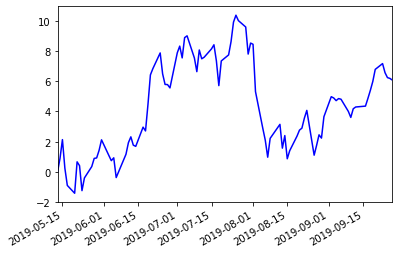

2019-05-08    68.310204
2019-05-09    66.582041
2019-05-10    66.127143
2019-05-13    64.011633
2019-05-14    64.579388
2019-05-15    65.378980
2019-05-16    64.166531
2019-05-17    63.438571
2019-05-20    63.107347
2019-05-21    64.437755
2019-05-22    64.274694
2019-05-23    63.217347
2019-05-24    63.755102
2019-05-27    64.237347
2019-05-28    64.583878
2019-05-29    64.602449
2019-05-30    64.924286
2019-05-31    65.370204
2019-06-03    64.706735
2019-06-04    64.488163
2019-06-05    64.607959
2019-06-06    63.771429
2019-06-10    64.757551
2019-06-11    65.250204
2019-06-12    65.496735
2019-06-13    65.144082
2019-06-14    65.094082
2019-06-17    65.907143
2019-06-18    65.747347
2019-06-19    66.867347
                ...    
2019-08-16    64.908571
2019-08-19    65.529592
2019-08-20    65.781020
2019-08-21    65.866122
2019-08-22    66.287347
2019-08-23    66.617755
2019-08-26    64.719592
2019-08-27    65.133469
2019-08-28    65.581633
2019-08-29    65.444082
2019-08-30    66

In [67]:
start_capital = close[method].mean(axis=1)
equality = (start_capital[3:]/start_capital[3]-1)*100
equality.plot(color = 'blue')
plt.show()
print(close[method].mean(axis=1))

# 將稅後純益率的分佈畫成直方圖

Text(0, 0.5, 'Frequency')

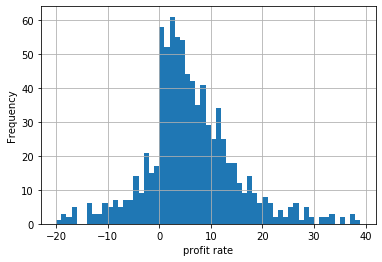

In [71]:
df['稅後純益率'].hist(bins = range(-20,40))
plt.xlabel('profit rate')
plt.ylabel('Frequency')